<a href="https://colab.research.google.com/github/lokeshkumarn/Notebooks/blob/master/FashionMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries/Dataset

### Import Libraries

In [ ]:
import time
import tensorflow as tf
from tensorflow.python.client import device_lib
from google.colab import drive

import pandas as pd
import numpy as np
import random as rd

from tensorflow import keras

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from matplotlib import pyplot as plt

In [ ]:
rd.seed(2020)         # Initialize the random number generator.
np.random.seed(2020)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(2020)  # sets the graph-level random seed

### Import Dataset

Load dataset from TF

In [26]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


### Check GPU

In [ ]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' ]

gpu_lst = get_available_gpus()

if(len(gpu_lst) > 0):
  print("GPU Enabled")
else:
  print("GPU Disabled")

GPU Enabled


## Data Visualization

Plot at least one sample from each class of the dataset 

In [31]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

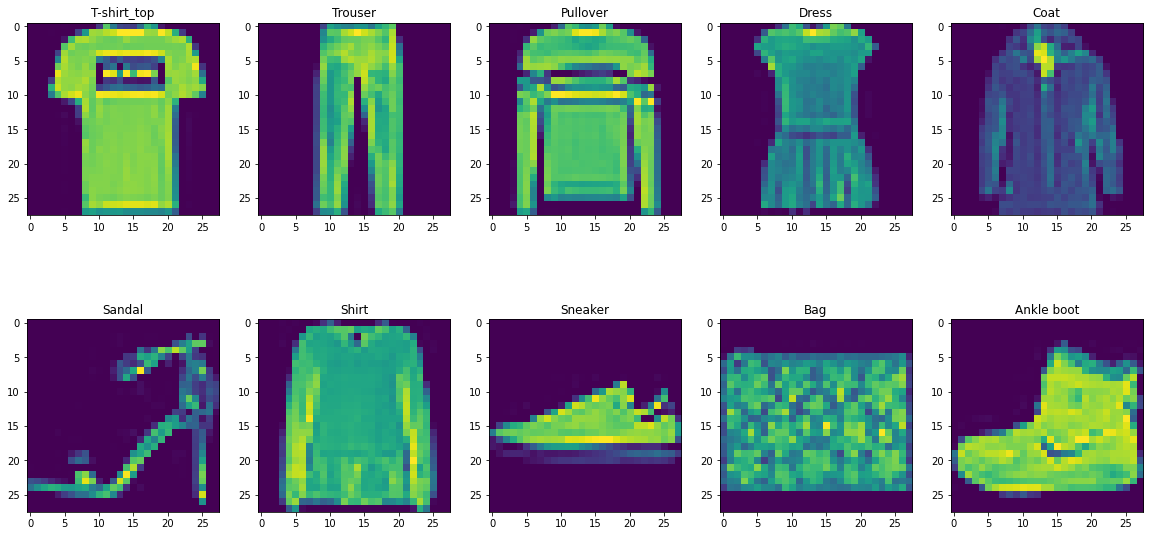

In [50]:
fig,ax = plt.subplots(2,5,figsize=(20,10))
j = 0
for c in enumerate(class_names):
  idx = [i for i,v in enumerate(y_train) if c[0] == v][0]
  row,col = j, c[0] % 5  
  ax[row,col].imshow(X_train[idx])
  ax[row,col].set_title(c[1])
  if c[0] % 5 == 4:
    j = j + 1